# 🎗️[Custom Preprocessor] RSNA Breast Cancer
---

The purpose of **preprocessing the images** of the [*RSNA Breast Cancer Detection Competition*](https://www.kaggle.com/competitions/rsna-breast-cancer-detection) is to get them into a consistent format and to remove any irrelevant or noisy data that may interfere with our model's ability to learn. By preprocessing the images, we can improve the performance and accuracy of our model, as well as make the training process more efficient.

Preprocessing the images is an important step in the machine learning pipeline, as it allows us to extract valuable features from the data and feed them into our model. Without preprocessing, our model may have to work harder to find patterns in the raw data, which can lead to overfitting or poor generalization to new data.

Overall, preprocessing the images in our dataset is an essential step that helps us prepare the data for training and improve the performance of our model.

**Last Version (V2):** January 17th 2023

[See version changelog](#Versions)

# Getting started
## Import packages

In [1]:
# Install required libraries
!pip install -qU python-gdcm pydicom pylibjpeg
!pip install -qU dicomsdl

# Standard library imports
import os
import time

# Third-party library imports
import numpy as np
import pandas as pd
import cv2
import pydicom
import dicomsdl

# Visualization library imports
import matplotlib.pyplot as plt

# Progress bar library imports
from tqdm.notebook import tqdm, trange

# Parallel processing library imports
from joblib import Parallel, delayed

## Get data paths
- Path to the CSV metadata
- Path to the training images

In [2]:
csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
data = pd.read_csv(csv_path)

# Utils

This section includes utility functions that are used in the notebook.
- `get_paths`: prepare the inputs of the *MammographyPreprocessor* methods
- `calculate_aspect_ratios`: preprocessing resizing shape decision support tool

### get_paths
This function generates and returns a list of n paths of the DICOM files, using data from the CSV file. If desired, the paths can be shuffled to produce a random selection, otherwise, the paths will be returned in their original order. In addition to the paths, this function also returns a cache, which is a list of dictionaries that map the patient IDs and scan IDs for each file. If n is omitted, all paths are obtained

In [3]:
def get_paths(n: int=len(data), shuffle: bool=False):
    if shuffle == True:
        df = data.sample(frac=1, random_state=0)
    else:
        df = data
    paths = []
    ids_cache = []
    for i in range(n):
        patient = str(df.iloc[i]['patient_id'])
        scan = str(df.iloc[i]['image_id'])
        paths.append(train_path + '/' + patient + '/' + scan + '.dcm')
        ids_cache.append({'patient_id': patient, 'scan_id': scan})
    return paths, ids_cache


# Example
paths, _ = get_paths(n=5, shuffle=True)
paths

['/kaggle/input/rsna-breast-cancer-detection/train_images/58224/132390955.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/21809/1307476428.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/58351/1689606258.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/60826/1465194139.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/1250/1329687627.dcm']

### calculate_aspect_ratios

This function returns a list of the aspect ratios (height to width) of the images specified by the filepaths to DICOM files. An optional preprocessor can be provided, which can crop the images before the aspect ratios are calculated. The purpose of this is to have an idea of the average aspect ratio of the cropped images over the dataset. Maybe the mammograms do not necessarily need to be square (e.g. 256x256, 512x512, 1024x1024), and a different aspect ratio may be more appropriate in order to reduce the pixel distorsion (e.g. 256x512, 512x768, 1024x1280).

In [4]:
def calculate_aspect_ratios(paths: list, preprocessor=None):
    ratios = []
    for i in trange(len(paths)):
        if preprocessor:
            img = preprocessor.preprocess_single_image(paths[i])
        else:
            scan = pydicom.dcmread(paths[i])
            img = scan.pixel_array
        height, width = img.shape
        ratio = height / width
        ratios.append(ratio)
    return ratios


# Example
ratios = calculate_aspect_ratios(paths)
print("Ratios:", ratios)
print("Min:", np.min(ratios))
print("Max:", np.max(ratios))
print("Avg:", np.mean(ratios))

  0%|          | 0/5 [00:00<?, ?it/s]

Ratios: [1.3, 1.1985370950888192, 1.2307692307692308, 1.279030910609858, 1.0895218718209563]
Min: 1.0895218718209563
Max: 1.3
Avg: 1.219571821657773


# Custom class: MammographyPreprocessor

*Sources:*
- Modular Approach: https://www.kaggle.com/code/onkur7/image-preprocessing-modular-approach/notebook
- Windowing: https://www.kaggle.com/code/davidbroberts/mammography-apply-windowing/notebook

The MammographyPreprocessor class purpose is to preprocess the raw images of the [*RSNA Breast Cancer Detection Competition*](https://www.kaggle.com/competitions/rsna-breast-cancer-detection) using different technics.

### Preprocessing steps
The steps for a single image are the following:
- **Windowing**: improve the contrast of images the way they are intended to be viewed
- **Fix the photometric interpretation**: set all image backgrounds to zero
- **Rescale with slope and intercept**: it seems like it is not necessary but just in case
- **Normalize between 0 and 255**: convert to 8-bits pixel values, grayscale
- **Flip the breasts**: flip the breasts on the same side for more consistency
- **Crop the background**: remove extra background
- **Resize**: make all images the same size for the future model
- **Save the image**: PNG default, JPEG optional

### Create an instance
To create an instance of the class, you only need to specify:
- **size** (*optional*): the dimensions of the resized images (if not specified, the images are not resized) ⚠️ **Size is given with the OpenCV convention (Width x Height)**. 
- **breast_side** (*default: 'L'*): the side where you want all the breasts to be reversed


### Public methods
You can use the following public methods:
- **get_paths()**: Return a list of n paths from the instance dataframe optional shuffling. **(V2)**
 - *n: int*
 - *shuffle: bool*
 - *return_cache: bool*
- **read_image()**: Returns the image array of a single DICOM file.
 - *path: str*
- **preprocess_all()**: Preprocess all the files of the list and save them by default as PNG. You can choose to do the preprocessing in parallel with the associated number of jobs.
 - *paths: list*
 - *save: bool*
 - *save_dir: bool*
 - *png: bool*
 - *parallel: bool*
 - *n_jobs: int*
- **preprocess_single_image()**: Returns the array of a single preprocessed file. You can choose to save it if you want to.
 - *path: str*
 - *save: bool*
 - *save_dir: bool*
 - *png: bool*
- **display()**: Display a grid of chosen rows and columns from the DICOM paths. You can choose to preprocess them before and to save the display on the working directory.
 - *paths: str*
 - *rows: int*
 - *cols: int*
 - *preprocess: bool*
 - *cmap: matplotlib colormap*
 - *cbar: matplotlib colorbar*
 - *save_fig: bool*
 - *save_name: str*

In [5]:
class MammographyPreprocessor():
    
    # Constructor
    def __init__(self, size: tuple=None, breast_side: str='L',
                 csv_path=None, train_path=None):
        self.size = size
        os.makedirs(os.getcwd(), exist_ok=True)
        self.breast_side = breast_side
        assert breast_side in ['L', 'R'], "breast_side should be 'L' or 'R'"
        # implement the paths of the original RSNA dataset (V2)
        self.csv_path = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
        self.train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
        if csv_path:
            self.csv_path = csv_path
        if train_path:
            self.train_path = train_path
        self.df = pd.read_csv(self.csv_path)
    
    # Get the paths from the preprocessor (V2)
    def get_paths(self, n: int=None, shuffle: bool=False, return_cache: bool=False):
        if n == None:
            n = len(self.df)
        if shuffle == True:
            df = self.df.sample(frac=1, random_state=0).copy()
        else:
            df = self.df.copy()
        paths = []
        ids_cache = []
        for i in range(n):
            patient = str(df.iloc[i]['patient_id'])
            scan = str(df.iloc[i]['image_id'])
            paths.append(self.train_path + '/' + patient + '/' + scan + '.dcm')
            ids_cache.append({'patient_id': patient, 'scan_id': scan})
        if return_cache:
            return paths, ids_cache
        else:
            return paths
    
    # Read from a path and convert to image array
    def read_image(self, path: str):
        scan = pydicom.dcmread(path)
        img = scan.pixel_array
        return img
    
    # Apply the preprocessing methods on one image
    def preprocess_single_image(self, path: str, save: bool=False,
                                save_dir: str=None, png: bool=True):
        scan = dicomsdl.open(path)
        img = scan.pixelData()
        img = self._fix_photometric_interpretation(img, scan)
        img = self._windowing(img, scan)
        img = self._normalize_to_255(img)
        img = self._flip_breast_side(img, scan)
        img = self._crop(img)
        if self.size:
            img = self._resize(img)
        if save:
            self._save_image(img, path, png, save_dir)
        return img
    
    # Preprocess all the images from the paths
    def preprocess_all(self, paths: list, save: bool=True,
                       save_dir: str='train_images', png: bool=True,
                       parallel: bool=False, n_jobs: int=4):
        clock = time.time()
        if parallel:
            Parallel(n_jobs=n_jobs) \
            (delayed(self.preprocess_single_image) \
            (path, save, save_dir, png) for path in tqdm(paths, total=len(paths)))
            print("Parallel preprocessing done!")
        else:
            for i in trange(len(paths)):
                self.preprocess_single_image(paths[i], save, save_dir, png)
            print("Sequential preprocessing done!")
        print("Time =", np.around(time.time() - clock, 3), 'sec')
    
    # Display the images from the dicom paths with optional preprocessing
    def display(self, paths: list, rows: int, cols: int,
                preprocess: bool=False, cmap='bone', cbar: bool=False,
                save_fig: bool=False, save_name: str='myplot.png'):
        assert len(paths) >= (rows * cols), \
        f"Not enough paths for the display. " \
        f"Please give at least {rows * cols} paths."
        plt.figure(figsize=(18, 26 * rows / cols))
        for i in trange(rows * cols):
            path = paths[i]
            if preprocess:
                img = self.preprocess_single_image(path, save=False)
            else:
                img = self.read_image(path)
            plt.subplot(rows, cols, i+1)
            plt.imshow(img, cmap=cmap)
            if cbar:
                plt.colorbar()
            plt.grid(False)
            plt.title(path.split('/')[-1][:-4])
        plt.suptitle("Preprocessed images" if preprocess \
                     else "Raw images", fontsize=25)
        if save_fig:
            plt.savefig(save_name, facecolor='white')
        plt.show()
    
    # Adjust the contrast of an image
    def _windowing(self, img, scan):
        function = scan.VOILUTFunction
        if type(scan.WindowWidth) == list:
            center = scan.WindowCenter[0]
            width = scan.WindowWidth[0]
        else:
            center = scan.WindowCenter
            width = scan.WindowWidth
        y_range = 2**scan.BitsStored - 1
        if function == 'SIGMOID':
            img = y_range / (1 + np.exp(-4 * (img - center) / width))
        else: # LINEAR
            below = img <= (center - width / 2)
            above = img > (center + width / 2)
            between = np.logical_and(~below, ~above)
            img[below] = 0
            img[above] = y_range
            img[between] = ((img[between] - center) / width + 0.5) * y_range
        return img
    
    # Interpret pixels in a consistant way
    def _fix_photometric_interpretation(self, img, scan):
        if scan.PhotometricInterpretation == 'MONOCHROME1':
            return img.max() - img
        elif scan.PhotometricInterpretation == 'MONOCHROME2':
            return img - img.min()
        else:
            raise ValueError("Invalid Photometric Interpretation: {}"
                               .format(scan.PhotometricInterpretation))
    
    # Cast into 8-bits for saving
    def _normalize_to_255(self, img):
        if img.max() != 0:
            img = img / img.max()
        img *= 255
        return img.astype(np.uint8)
    
    # Flip the breast horizontally on the chosen side 
    def _flip_breast_side(self, img, scan):
        img_breast_side = self._determine_breast_side(img)
        if img_breast_side == self.breast_side:
            return img
        else:
            return np.fliplr(img)    
    
    # Determine the current breast side
    def _determine_breast_side(self, img):
        col_sums_split = np.array_split(np.sum(img, axis=0), 2)
        left_col_sum = np.sum(col_sums_split[0])
        right_col_sum = np.sum(col_sums_split[1])
        if left_col_sum > right_col_sum:
            return 'L'
        else:
            return 'R'
    
    # Crop the useless background of the image
    def _crop(self, img):
        bin_img = self._binarize(img, threshold=5)
        contour = self._extract_contour(bin_img)
        img = self._erase_background(img, contour)
        x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
        y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
        x1, x2 = int(0.99 * x1), int(1.01 * x2)
        y1, y2 = int(0.99 * y1), int(1.01 * y2)
        return img[y1:y2, x1:x2]
    
    # Binarize the image at the threshold
    def _binarize(self, img, threshold):
        return (img > threshold).astype(np.uint8)
    
    # Get contour points of the breast
    def _extract_contour(self, bin_img):
        contours, _ = cv2.findContours(
            bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)
        return contour
    
    # Set to background pixels of the image to zero
    def _erase_background(self, img, contour):
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        output = cv2.bitwise_and(img, mask)
        return output
    
    # Resize the image to the preprocessor size
    def _resize(self, img):
        return cv2.resize(img, self.size)
    
    # Get the save path of a given dicom file
    def _get_save_path(self, path, png, save_dir):
        patient = path.split('/')[-2]
        filename = path.split('/')[-1]
        if png:
            filename = filename.replace('dcm', 'png')
        else:
            filename = filename.replace('dcm', 'jpeg')
        if save_dir:
            save_path = os.path.join(os.getcwd(), save_dir, patient, filename)
        else:
            save_path = os.path.join(os.getcwd(), patient, filename)
        return save_path
    
    # Save the preprocessed image
    def _save_image(self, img, path, png, save_dir):
        save_path = self._get_save_path(path, png, save_dir)
        patient_folder = os.path.split(save_path)[0]
        os.makedirs(patient_folder, exist_ok=True)
        cv2.imwrite(save_path, img)

## Tutorial
### First, get the paths!


In [6]:
# Test with 100 files 
paths, _ = get_paths(n=100, shuffle=True)

### Create a MammographyPreprocessor instance
Let's set the final resize to 256x256 pixels. It might not be the best to train a good model, but it is fine for a baseline.

In [7]:
mp = MammographyPreprocessor(size=(256, 256))
mp

### Read a raw file
This can be useful to start a quick EDA.

⚠️ **Shameful personal promotion:** You can check mine [here](https://www.kaggle.com/code/paulbacher/eda-breast-cancer-detection-competition)! 🙃

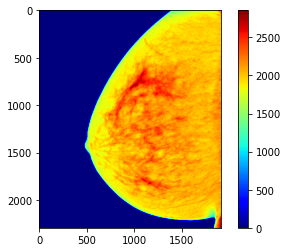

In [8]:
# Select the first file of the list
path = paths[12]

# Load the image array
img = mp.read_image(path=path)

# Display what has been loaded
plt.imshow(img, cmap='jet')
plt.colorbar()
plt.show()

### Preprocess a single image
To quickly check the result after preprocessing a given image, you can do it as follow.

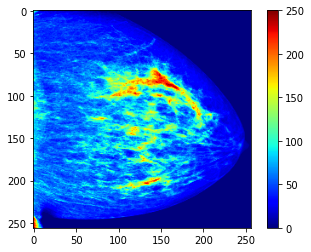

In [9]:
# Preprocess from the same previous path
img = mp.preprocess_single_image(path=path, save=False)

# Display the preprocessed image
plt.imshow(img, cmap='jet')
plt.colorbar()
plt.show()

As expected, the raw image has been cropped and resized to a square of **256x256** pixels among other preprocessing steps.

### Preprocess all the images
To efficiently preprocess all of your images, you can use the specified method on your list of file paths. In this case, since there are only 100 files, the preprocessing will be completed quickly. Keep in mind that there are 54706 files to preprocess in the full training set and this will easily take several hours, depending on the way you preprocess them.

The resulting grayscale PNG images will be saved in the current working directory, the same structure as the input files were.

For the example, I am using parallel computation on the 4 cores of the CPU. This is faster but not necessarily by a factor of 4. You can also use the GPU to increase the speed of preprocessing.

In [10]:
mp.preprocess_all(paths, save=True, save_dir='train_images', parallel=True, n_jobs=4)

  0%|          | 0/100 [00:00<?, ?it/s]

Parallel preprocessing done!
Time = 39.172 sec


### Display many examples
This goes along with what has been explained previously. Just use the parameters you want. 😊

The images are reloaded from the original paths and preprocessing can be done before displaying. It can take a few seconds for a large number of images.

First I will display a grid of raw images.

  0%|          | 0/15 [00:00<?, ?it/s]

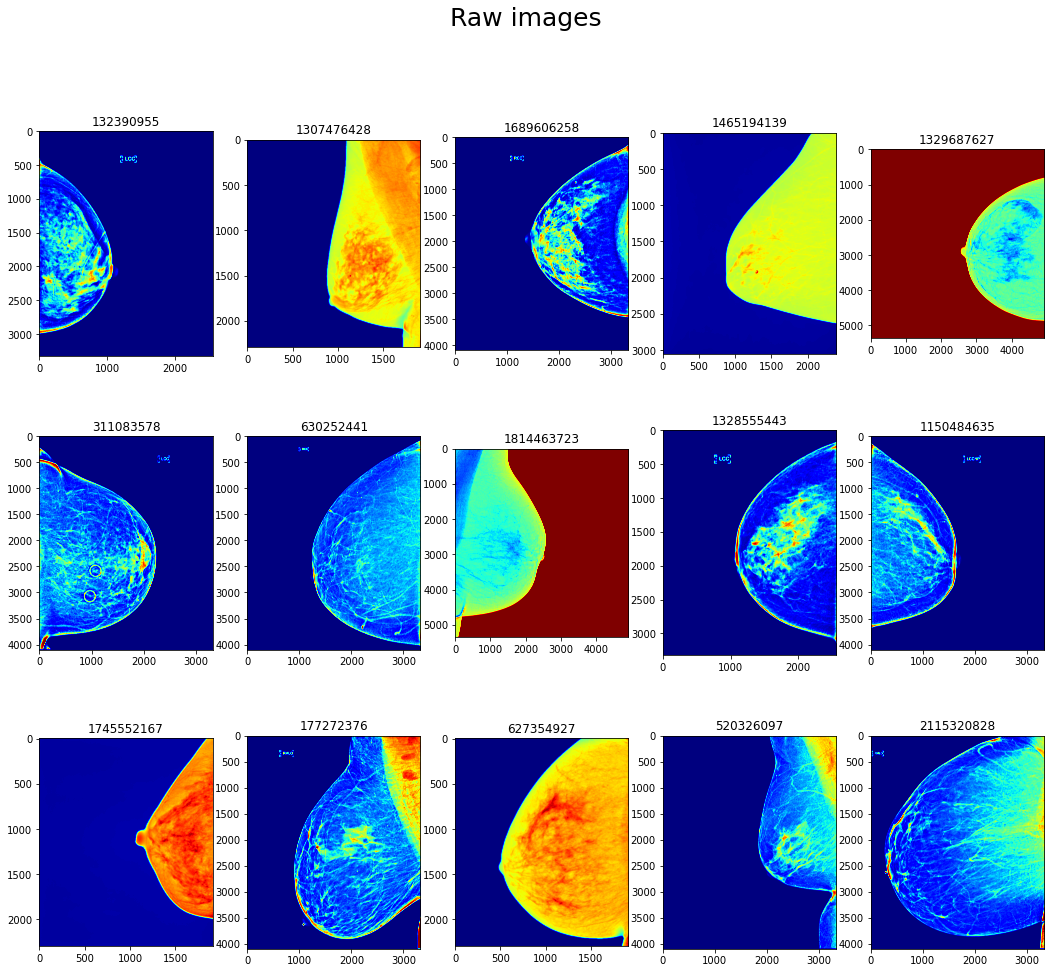

In [11]:
# Images before preprocessing
mp.display(paths, rows=3, cols=5, preprocess=False, cmap='jet', save_fig=False)

As we can see, the raw images are not very consistant in there shapes, pixel values, or orientation.

Let's have a look at the same images after preprocessing by just setting preprocess to *True*.

  0%|          | 0/15 [00:00<?, ?it/s]

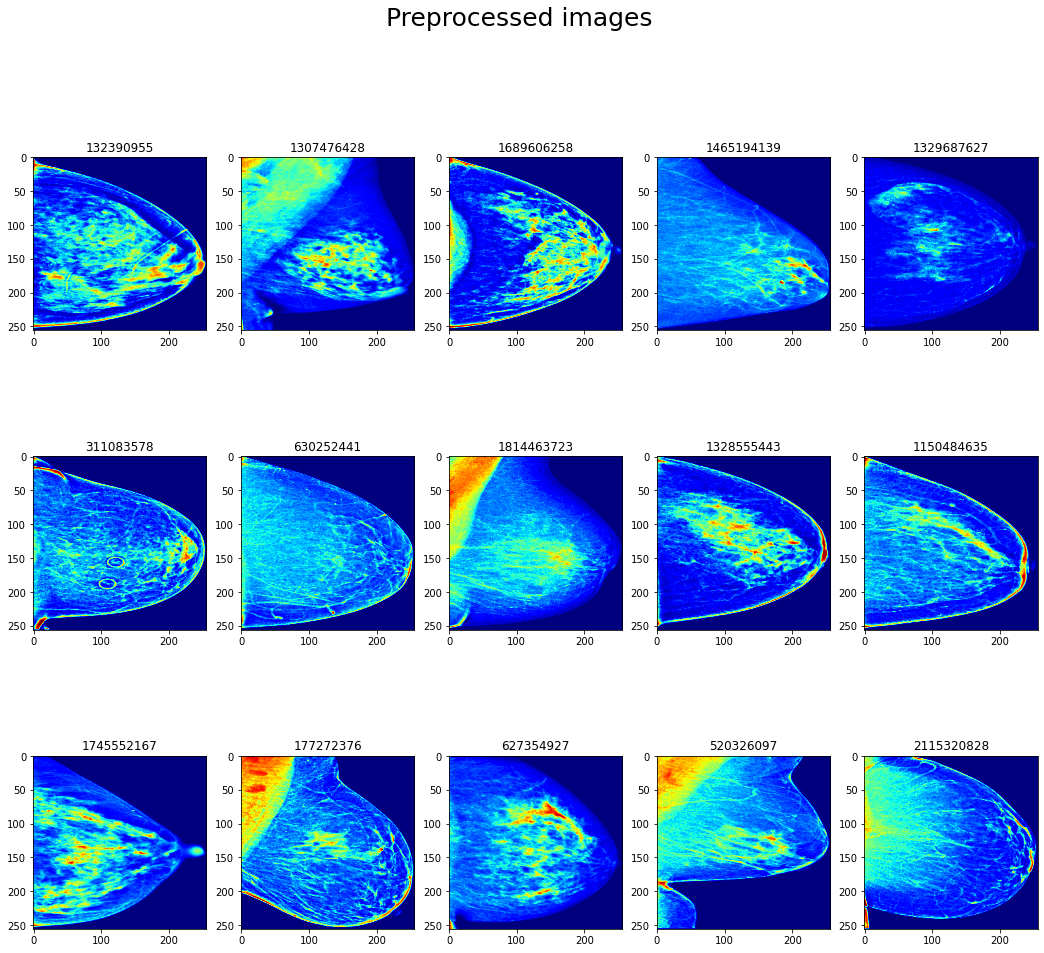

In [12]:
# Images after preprocessing
mp.display(paths, rows=3, cols=5, preprocess=True, cmap='jet', save_fig=False)

It looks way better like this! Now we can expect our future model to learn better with a good preprocessing.

# About resizing parameter
At the beginning of the notebook, I wrote a function that returns a list of the image ratios. I would like to try something now.

Let's calculate the average size ratio of several breasts just after preprocessing them but without applying the resize method yet.

In [13]:
# Get more file paths
paths, _ = get_paths(n=300, shuffle=True)

# Create a new preprocessor with no resize value
mp = MammographyPreprocessor()

# Calculate the size ratios with the preprocessor
ratios = calculate_aspect_ratios(paths, preprocessor=mp)
print("Min ratio:", np.min(ratios))
print("Max ratio:", np.max(ratios))
print("Med ratio:", np.median(ratios))

  0%|          | 0/300 [00:00<?, ?it/s]

Min ratio: 1.2772277227722773
Max ratio: 4.713375796178344
Med ratio: 2.096771760813507


Once cropped, the 300 sample images have a median aspect ratio of 2.1 and are rectangular in shape. Resizing these images is necessary for computational purposes, but it results in the loss of some information due to compression. When the cropped images are resized into squares, the information is not lost evenly in all directions. Instead, the images tend to be more compressed vertically than horizontally. We can clearly see this horizontal distortion in the previous plot.

To minimize this effect, it might be helpful to resize the images into a shape that is closer to their median aspect ratio, which appears to be around 2. Possible resize dimensions that could achieve this might include **128x256**, **256x512**, or **512x1024**.

Let's have a look at it.

  0%|          | 0/15 [00:00<?, ?it/s]

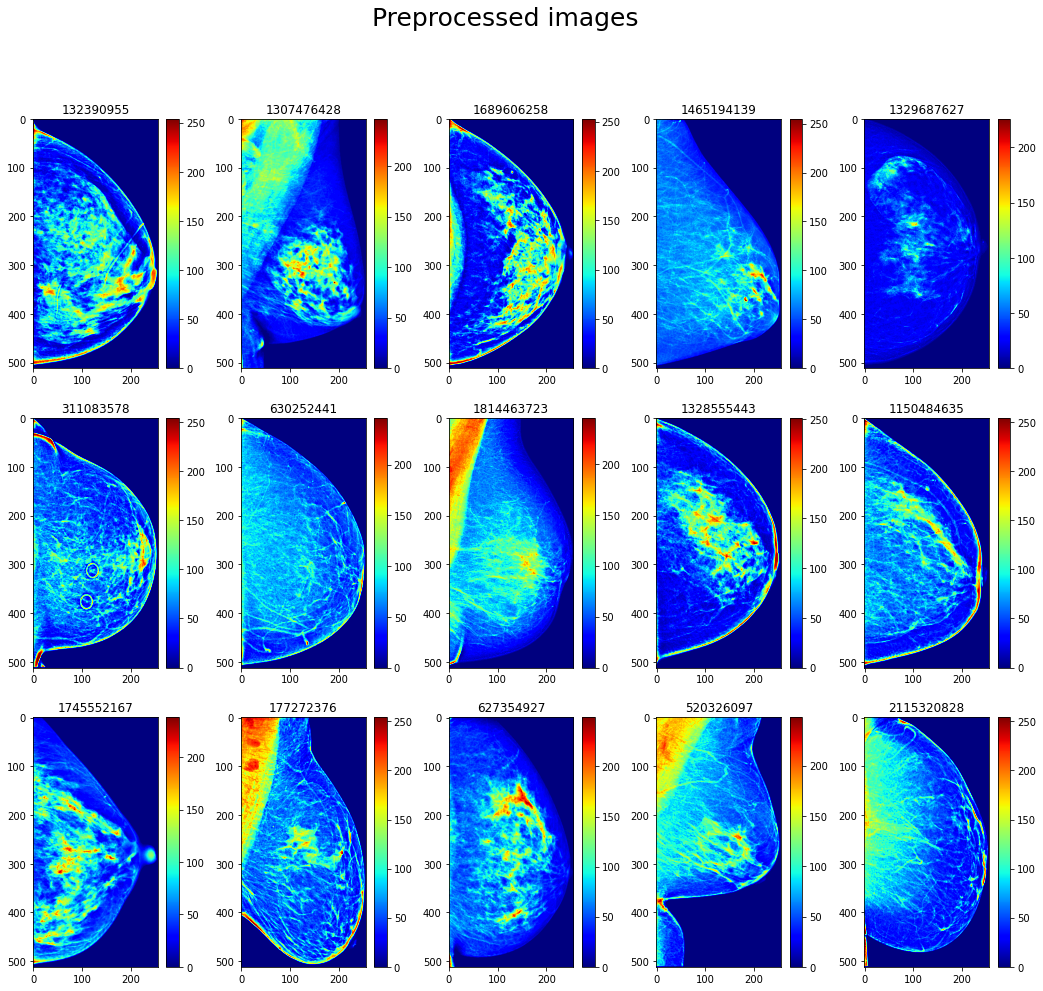

In [14]:
# Define first the new size value
mp = MammographyPreprocessor(size=(256, 512)) # OpenCV convention (Width x Height)
mp.display(paths, rows=3, cols=5, preprocess=True, cmap='jet', cbar=True, save_fig=False)

Here we go, pixel distortion is still present but to a lesser extent. What could completely remove this distortion would be to resize the images while keeping their aspect ratio then add a padding on one of the sides. This is a planned option for the next release.

This has been suggested to me by [Remek Kinas](https://www.kaggle.com/remekkinas).

**Let me know your suggestions about this topic!**

# How to install the preprocessor on your notebook
Copy-paste these two lines at the top of your notebook and you will be able to use the `MammographyPreprocessor`!

In [15]:
# !pip install git+https://github.com/Paul-Bacher/RSNA-Screening-Mammography-Breast-Cancer-Detection.git#subdirectory=rsna_custom
# from rsna_custom import MammographyPreprocessor

# Versions
- **V1:**
 - The MammographyPreprocessor class can load and preprocess mammography images, including: applying windowing, rescaling and normalizing pixel values, flipping the side, cropping and resizing
 - It allows for the display and saving of raw and preprocessed images, including the option to save preprocessed images as PNG files in the original folder structure.
 - It can process a single image or multiple images from a list of file paths.
- **V2:**
 - The `get_paths` function has been implemented inside of the preprocessor class.
 - Loading before preprocessing is now done via `dicomsdl` which seems to save about 35-40% of computation time.
 - Add a parameter for the saving destination of the image
- **V3: (UPCOMING)**
 - Add an outliers detector
 - ...

# Endnotes
- I will keep updating my custom class with new public methods that could be useful or with new preprocessing steps that I can find.
- Please, let me know in the comments if you find any bug. Also, I would be glad if you suggest me ways to improve my class, like saving computation time. I am also learning a lot from this work!
- Of course, you are free to use my class and modify it for your own purpose.

**Thank you for reading**, please upvote my work if you found it interesting. 😄